# Randomized Eigendecomposition by Power Iteration

### Motivation / Why this needs to be done:

Computing eigenvalues can be computationally expensive in the dimension of the matrix. We can see this below:


In [1]:
import numpy as np

In [2]:
%%time
A = np.random.random([50, 176000])
vals, vecs = np.linalg.eigh(A.dot(A.T))

CPU times: user 156 ms, sys: 376 ms, total: 532 ms
Wall time: 282 ms


In [3]:
%%time
A = np.random.random([500, 176000])
vals, vecs = np.linalg.eigh(A.dot(A.T))

CPU times: user 3.87 s, sys: 1.88 s, total: 5.75 s
Wall time: 1.57 s


In [4]:
%%time
A = np.random.random([1000, 176000])
vals, vecs = np.linalg.eigh(A.dot(A.T))

CPU times: user 15.9 s, sys: 7.73 s, total: 23.6 s
Wall time: 5.38 s


With neuroscience data being of extremely high dimension, we need a more scalable way to perform the eigendecomposition.

Note the specs of the system that produced these results:

```
                          ./+o+-       ryan@swagtop
                  yyyyy- -yyyyyy+      OS: Ubuntu 16.04 xenial
               ://+//////-yyyyyyo      Kernel: x86_64 Linux 4.4.0-45-generic
           .++ .:/++++++/-.+sss/`      Uptime: 7h 20m
         .:++o:  /++++++++/:--:/-      Packages: 2482
        o:+o+:++.`..```.-/oo+++++/     Shell: bash 4.3.46
       .:+o:+o/.          `+sssoo+/    Resolution: 1366x768
  .++/+:+oo+o:`             /sssooo.   DE: Unity 7.4.0
 /+++//+:`oo+o               /::--:.   WM: Compiz
 \+/+o+++`o++o               ++////.   WM Theme: Ambiance
  .++.o+++oo+:`             /dddhhh.   GTK Theme: Ambiance [GTK2/3]
       .+.o+oo:.          `oddhhhh+    Icon Theme: ubuntu-mono-dark
        \+.++o+o``-````.:ohdhhhhh+     Font: Ubuntu 11
         `:o+++ `ohhhhhhhhyo++os:      CPU: Intel Core i7-4700MQ CPU @ 3.4GHz
           .o:`.syhhhhhhh/.oo++o`      RAM: 2297MiB / 3863MiB
               /osyyyyyyo++ooo+++/    
                   ````` +oo+++o\:    
                          `oo++. 
```

whereas the s3 instances we will likely be working with have less than 3.0 GHz of CPU power.

### Power Iteration Theory and Pseudocode

Assume a matrix $A$ is positive definite and symmetric.

Then its eigenvalues can be written

$$\lambda_1 \geq \lambda_2 \geq \ldots \geq \lambda_n \gt 0$$

Suppose we choose a random vector $x$ and took $Ax$.

Then $x \in span\{A\}$ and thus can be written $x = \sum_{i=1}^n c_1v_1$ where $v_i$ is the $i^{th}$ eigenvector of $A$ and $n = dim(A)$.

In general $$Av_i = \lambda_iv_i \Rightarrow A^kv_i = \lambda_i^kv_i$$
so $$A^kx = \sum_{i=1}^n c_i\lambda_i^kv_i$$

assuming $c_1 \neq 0$ we can see

$$A^kx = c_1\lambda_1^k(v_1 + \sum_{i=2}^n c_i\frac{\lambda_i^k}{\lambda_1^k}v_i)$$

Now, if we are to assume that $\frac{\lambda_2}{\lambda_1} < 1$ then $\sum_{i=2}^n c_i\frac{\lambda_i^k}{\lambda_1^k}v_i$ will eventually converge to 0 as $k \rightarrow \infty$ by the condition that the eigenvalues are sort by index.

Thus, we will recover the eigenvector $v_1$ by normalizing the result. In fact, we should normalize the result after each step to prevent numerical overflow.

Also, we can only find $k$ eigenvalues with this method if we wanted, which means that the total running time of this eigendecomposition would be $O(k * m * n^2)$ where $m$ is the total number of iterations. We assuming the eigen-gap $\lambda_2/\lambda_1$ is not very small, we can keep $m$ much smaller than $n$.

The pseudocode is this:
Input: $X$, a PDS matrix of dimension $n$. $k$, a number of iterations.
Output: $v_1$, the top eigenvector of $X$

$ITER(X, k): \\
\,\,\,\, x = random(n\times 1) \\
\,\,\,\,\, x = Ax \\
\,\,\,\,\, \text{for } i \text{ in } [1, k]: \\
\,\,\,\,\,\, x = Ax \\
\,\,\,\,\,\,\, x = x / \vert\vert x \vert\vert \\
\,\,\,\,\, return\,\,x$

We can then deflate and find all the other eigenvectors similarly.

### Simulations, Qualitative, Quantitative

We can compute random matricies and their eigenvectors, then run our algorithm, then check the frobenius norm between the top k eigenvectors of the fully computed eigenvectors and our estimated eigenvectors close.

Simulations: Generate a random $n \times m$ matrix, and find the top $k$ eigenvectors of the covariance matrix using numpy libraries. Then do the same with our methods.

Quantitative results: Frobenius norm of our eigenmatrix with the 'true' eigenmatrix

Qualitative results: Plot of error as a function of # of iterations.

In [5]:
def power_iteration(A, x, k, prev):
    for i in xrange(k):
        x = A.dot(x)
        x = x / np.linalg.norm(x)
        for p in prev:
            x = x - x.dot(p) * p/np.linalg.norm(p)
    return x, x.T.dot(A).dot(x)/x.T.dot(x)
     

def deflate(A, k, m):
    evecs = []
    evs = []
    for i in range(k):
        x = np.random.random([A.shape[1],])
        v, l = power_iteration(A, x, m, evecs)
        evs.append(l)
        evecs.append(v)
    return np.column_stack([evecs]).T, np.column_stack([evs])


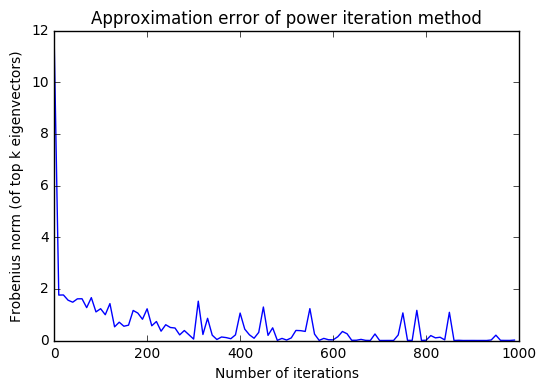

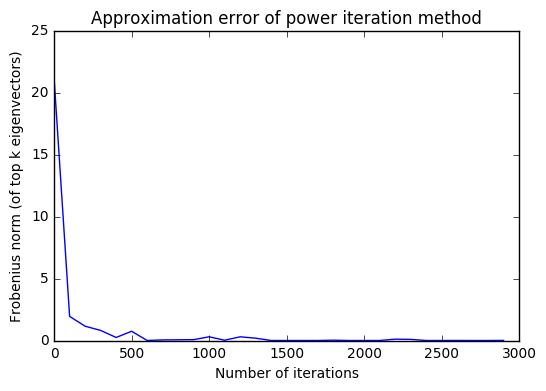

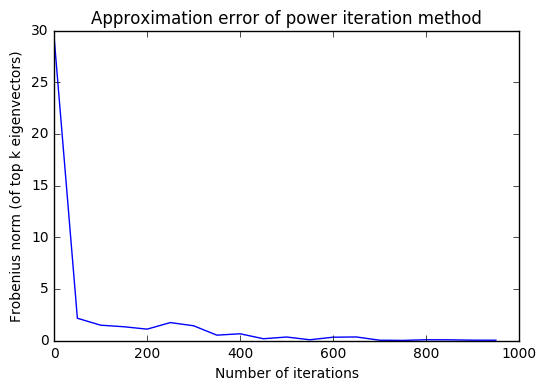

In [6]:
import matplotlib.pyplot as plt
M = np.arange(0, 1000, 10)
n = 100
t = 1760
k = 5
def qualitative_test(M, n, t, k):
    norms = []
    for i in M:
        A = np.random.normal(size=[n, t])
        A = A.dot(A.T)
        l, v = np.linalg.eigh(A)
        v_k = -1 * v[:, -k:][:, ::-1]
        evs, els= deflate(A, k, i)
        norms.append(np.linalg.norm(np.abs(v_k) - np.abs(evs)))
    plt.plot(M, norms)
    plt.title("Approximation error of power iteration method")
    plt.xlabel("Number of iterations")
    plt.ylabel("Frobenius norm (of top k eigenvectors)")
    plt.show()
qualitative_test(np.arange(0, 1000, 10), 100, 1760, 5)
qualitative_test(np.arange(0, 3000, 100), 200, 1000, 8)
qualitative_test(np.arange(0, 1000, 50), 300, 500, 10)

In [7]:
def speed_test_PI(n, t):
    k = 1
    for i in range(t):
        A = np.random.normal(size=[n, 500])
        A = A.dot(A.T)
        evs, els= deflate(A, k, 500)
        
def speed_test_EIGH(n,t):
    k = 1
    for i in range(t):
        A = np.random.normal(size=[n, 500])
        A = A.dot(A.T)
        l, v = np.linalg.eigh(A)
        v_k = -1 * v[:, -k:][:, ::-1]

In [8]:
%%time
speed_test_PI(100, 10)

CPU times: user 184 ms, sys: 600 ms, total: 784 ms
Wall time: 101 ms


In [9]:
%%time
speed_test_EIGH(100, 10)

CPU times: user 232 ms, sys: 808 ms, total: 1.04 s
Wall time: 137 ms


In [10]:
%%time
speed_test_PI(500, 10)

CPU times: user 1.15 s, sys: 1.71 s, total: 2.86 s
Wall time: 361 ms


In [11]:
%%time
speed_test_EIGH(500, 10)

CPU times: user 2.84 s, sys: 7.28 s, total: 10.1 s
Wall time: 1.27 s


In [12]:
%%time
speed_test_PI(1000, 10)

CPU times: user 13.9 s, sys: 6.18 s, total: 20 s
Wall time: 2.52 s


In [13]:
%%time
speed_test_EIGH(1000, 10)

CPU times: user 11.3 s, sys: 14.3 s, total: 25.5 s
Wall time: 3.21 s


In [14]:
%%time
speed_test_PI(5000, 2)

CPU times: user 2min 27s, sys: 10.4 s, total: 2min 37s
Wall time: 20.7 s


In [15]:
%%time
speed_test_EIGH(5000, 2)

CPU times: user 7min 30s, sys: 54.8 s, total: 8min 25s
Wall time: 1min 11s
